# Crypto Market Screening for strategy development

In this notebook we will explore the four major cryptos (Bitcoin, Ethereum, Litecoin, Ripple) from a technical point of view.
By technical we mean that only candlesticks prices will be considered for this analysis. 
We will be pulling data from the Binance API, and performing some analysis to asses which kind of strategy class, in the spot market, could work best in a context of short term trading.


This analysis is structured as follows:

- Part I: A study on the correlation among the cryptoassets. Is technical analysis enough?
- Part II: Market sentiment assessed by candlestick analysis.
- Part III: Are cryptocurrency prices mean reverting?

In [390]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from binance.client import Client
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


To achieve this analysis we have build some python modules that will help to pull the data and asses if the cryptoassets are *more likely* to be in a persistent behaviour or in an antipersistent behaviour. In simple words we asses if it could be more convenient to focus on a trend following strategy or on a mean reverting strategy.

In [3]:
from CryptoAnalytics.HurstPackage import HurstExponent, HurstIndicator
from CryptoAnalytics.MeanReversionFit import MeanReversion
from CryptoAnalytics.SentimentAnalysis import MarketSentiment
from CryptoAnalytics.correlation import ClassicCorrelation, DynamicConditionalCorrelation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We firstly start by looking at the correlation of the given cryptocurrency assets. To do so, we firstly pull some data from the binance API.

In [4]:
api_key = "MxSmc6ia6BA6BA60invAnXfoSolR8sigdbN9d8pCeSwlPq9VhqbovNrCHnp5rgV9"
secret_key = "6OezC4y724zTYDXKCyxfACXlUa3VKJjzZQG6RM79xdmph5d50fiIBaTE2nn9G4vL"


client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True) # Testnet!!!

In [18]:
def data_provider(symbol, bar_length, start, end = None):
    
    bars = client.get_historical_klines(symbol = symbol, interval = bar_length,
                                start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")


    df['log_change'] = np.log(df.Close / df.Close.shift(1))

    return df


In [6]:
client.get_all_tickers()

[{'symbol': 'BNBBUSD', 'price': '370.20000000'},
 {'symbol': 'BTCBUSD', 'price': '38614.18000000'},
 {'symbol': 'ETHBUSD', 'price': '2554.41000000'},
 {'symbol': 'LTCBUSD', 'price': '102.80000000'},
 {'symbol': 'TRXBUSD', 'price': '0.05943000'},
 {'symbol': 'XRPBUSD', 'price': '0.72700000'},
 {'symbol': 'BNBUSDT', 'price': '370.00000000'},
 {'symbol': 'BTCUSDT', 'price': '38608.81000000'},
 {'symbol': 'ETHUSDT', 'price': '2553.87000000'},
 {'symbol': 'LTCUSDT', 'price': '102.40000000'},
 {'symbol': 'TRXUSDT', 'price': '0.05942000'},
 {'symbol': 'XRPUSDT', 'price': '0.72680000'},
 {'symbol': 'BNBBTC', 'price': '0.00958400'},
 {'symbol': 'ETHBTC', 'price': '0.06614800'},
 {'symbol': 'LTCBTC', 'price': '0.00265100'},
 {'symbol': 'TRXBTC', 'price': '0.00000154'},
 {'symbol': 'XRPBTC', 'price': '0.00001882'},
 {'symbol': 'LTCBNB', 'price': '0.28020000'},
 {'symbol': 'TRXBNB', 'price': '0.00016040'},
 {'symbol': 'XRPBNB', 'price': '0.00196200'}]

In [26]:
crypto_assets = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT']

daily_data = []

for crypto in crypto_assets:
    
    daily_data.append(data_provider(symbol = crypto,
                                    bar_length = '1m',
                                    start = (datetime.now() - timedelta(days = 90)).strftime('%Y-%m-%d')
                                   ).log_change)

In [65]:
data = pd.concat([daily_data[i] for i in range(len(daily_data))], axis = 1).dropna()
data.columns = crypto_assets

In [66]:
print('Number of Observations: {}'.format(data.shape[0]))

Number of Observations: 13527


Let us pick a sample of those observations and lets look at the sample correlation. Whereas the sample correlation could be low, in the rolling correlation we will see some spikes in correlation. This will be helpful to asses the speed of change in correlations among all those crypto-assets. This could be helpful not only in a pair-trading constext, but also in risk management. Indeed, the *delayed* correlation could be a predictor of assets moving up or down. However we should test this hypothesis, with some inferential statistical method.

We choose for this analysis the lowest possible time bar, which is the minute granularity.

In [129]:
corr = ClassicCorrelation(data[1000:], method = 'pearson')

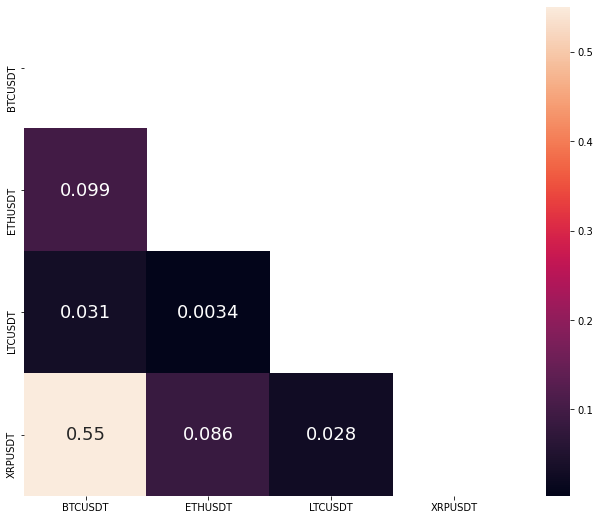

In [130]:
corr.sample_correlation()

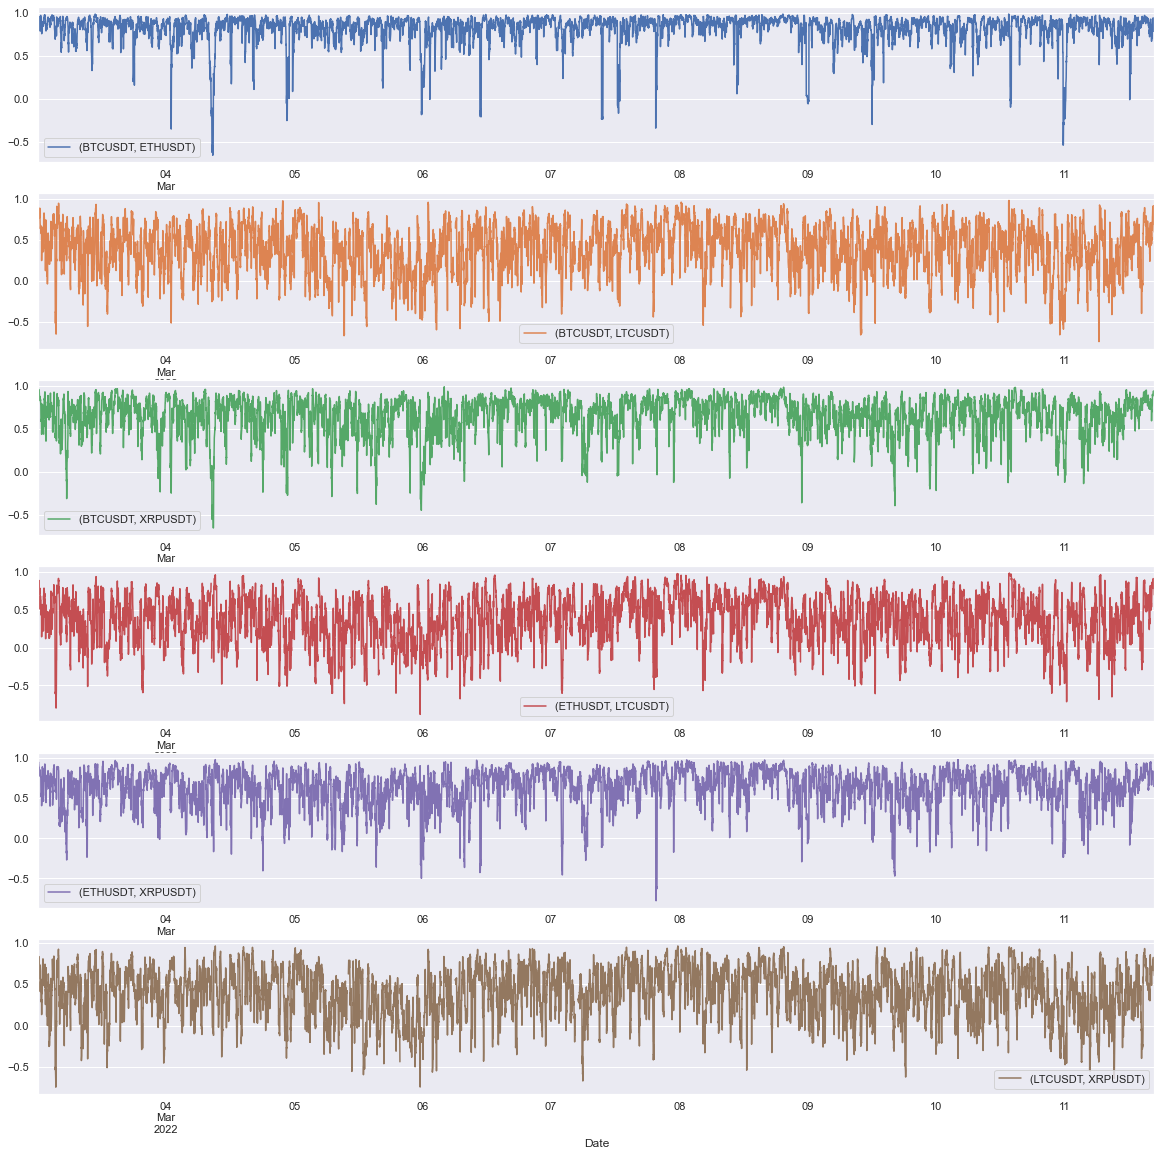

In [396]:
#Let's consider a 60 minutes window

corr.rolling_correlation(window = 15)

We can see that whereas some pairs spikes in correlation, other decorrelate. We can see that Bitcoin persists, up to some *valleys*, on showing high correlation with Ripple and Ethereum. Whereas Litecoin against Bitcoin shows an anti-persistent behaviour, indeed this pair, for this sample could be a potential candidate for a pair-trading strategy. However, pair-trading will not be object of this work. Let's move on with Bitcoin, Ethereum and Ripple. From the graph above, we can see some windows of latency in the decorrelation. Meaning that some *valleys* of decorrelation between Ethereum and Bitcoin react sligthly faster than the decorrelation between Ripple and Bitcoin. 

In [397]:
rolling_dataset = corr.corr_dataset

In [398]:
focus_analysis = rolling_dataset[[rolling_dataset.columns[0], 
                                  rolling_dataset.columns[2],
                                  rolling_dataset.columns[4]]]

In [399]:
focus_analysis.columns = ['btceth', 'btcxrp', 'ethxrp']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1a42d3af0>,
      dtype=object)

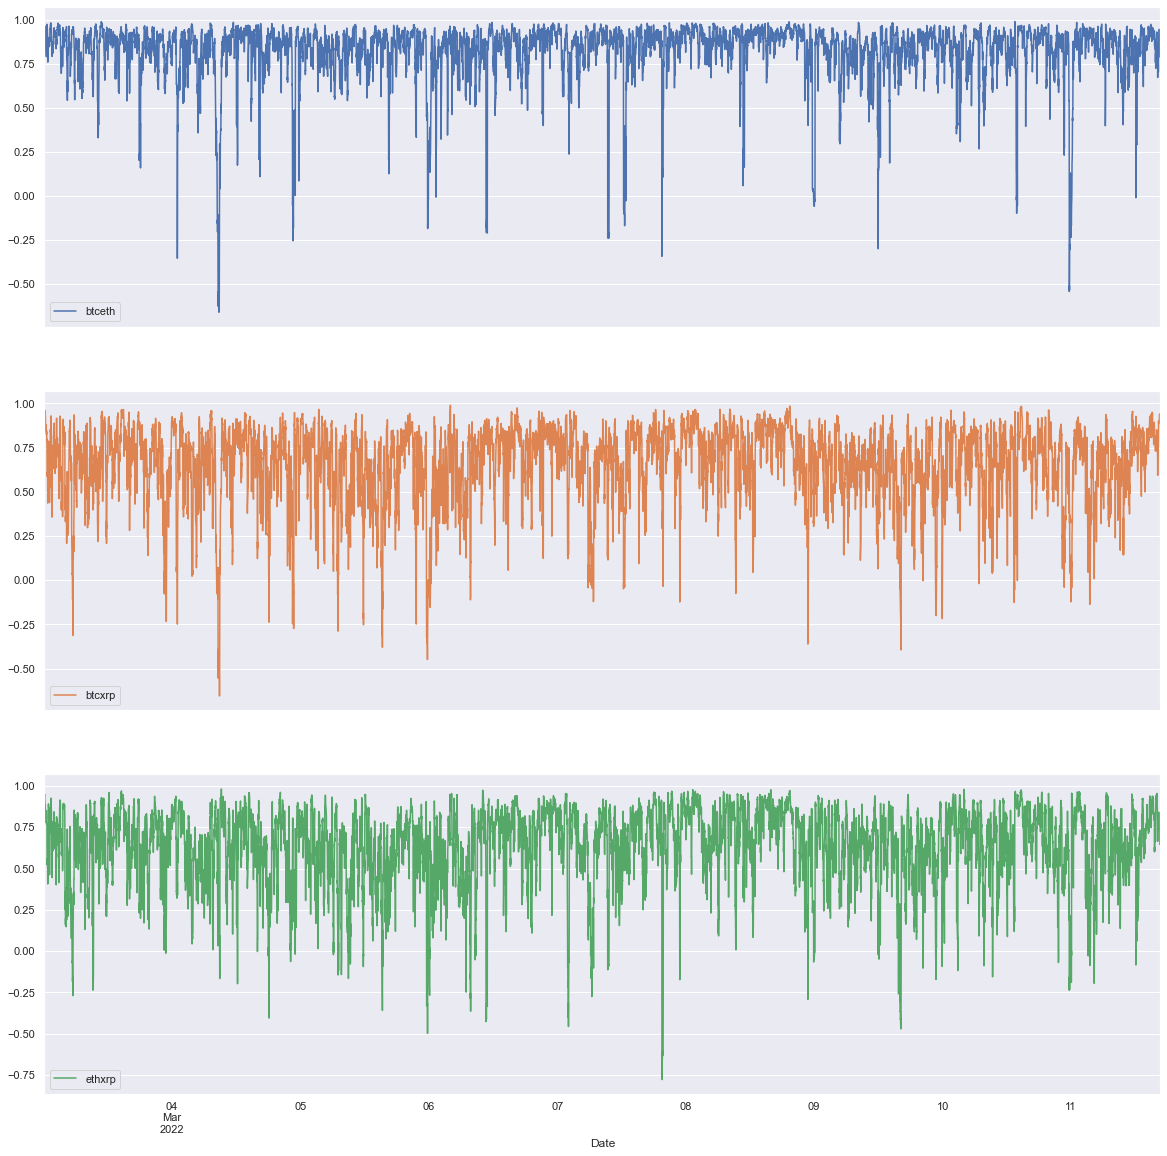

In [400]:
focus_analysis.plot(figsize = (20,20), grid = True, subplots = True)

Lets check if the maximal correlations and the minimal correlations are syncronous

In [401]:
print('-'*100)

print('Maximal Correlation BTCETH {} | Achieved on {}'.format(focus_analysis.max().btceth,
                                                              focus_analysis.idxmax().btceth))
print('\n')

print('Maximal Correlation BTCXRP {} | Achieved on {}'.format(focus_analysis.max().btcxrp,
                                                              focus_analysis.idxmax().btcxrp))

print('-'*100)

print('Minimal Correlation BTCETH {} | Achieved on {}'.format(focus_analysis.min().btceth,
                                                              focus_analysis.idxmin().btceth))
print('\n')

print('Maximal Correlation BTCXRP {} | Achieved on {}'.format(focus_analysis.min().btcxrp,
                                                              focus_analysis.idxmin().btcxrp))

print('-'*100)




----------------------------------------------------------------------------------------------------
Maximal Correlation BTCETH 0.9899997243702338 | Achieved on 2022-03-10 13:30:00


Maximal Correlation BTCXRP 0.9899576578428078 | Achieved on 2022-03-06 04:02:00
----------------------------------------------------------------------------------------------------
Minimal Correlation BTCETH -0.6604206445320742 | Achieved on 2022-03-04 08:47:00


Maximal Correlation BTCXRP -0.654212768355068 | Achieved on 2022-03-04 08:53:00
----------------------------------------------------------------------------------------------------


In this sample we can observe non syncronous extremals.

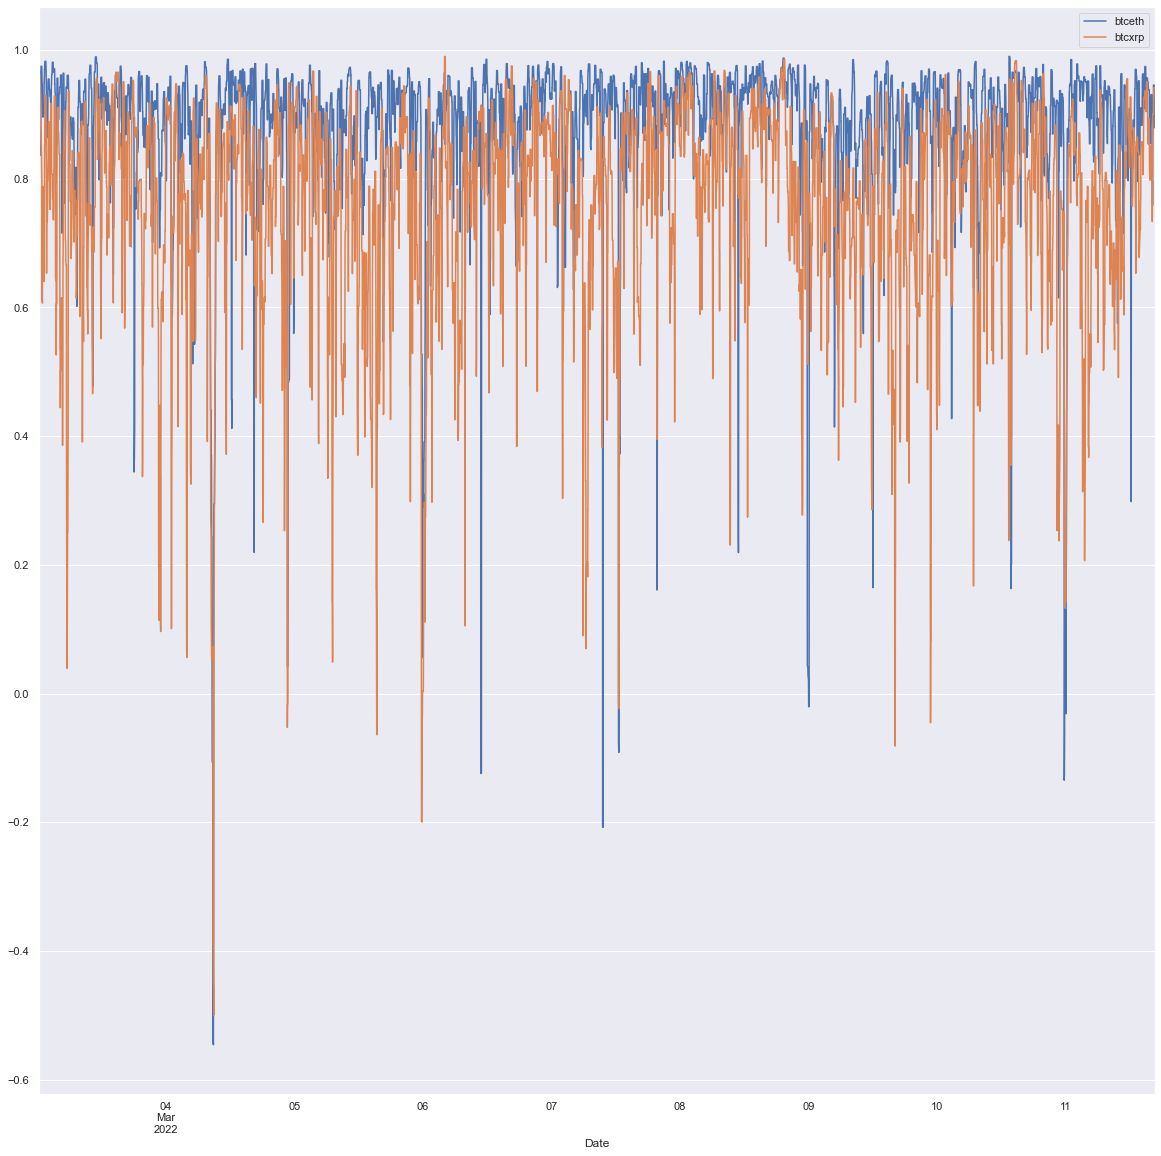

In [402]:
focus_analysis.rolling(window=10).max()[['btceth', 'btcxrp']].plot(figsize = (20,20), grid = True)

We can asses that in this randomly chosen sample, there is a latency in the direction of the correlation between the two pairs. From the picture we can see that the pair BTCETH is slightly faster than BTCXRP. Translating this at the price level, this means that prices from BTC are more likely to change faster than XRP. Therefore, violent price changes in BTC will be most likely inherited to XRP with some latency. This latency could be used for riks management purpouses. However, a more extensive analysis on this phenomena should be carried on by looking at the fundamental data of these market. In this sense, BTC and ETH are minable cryptocurrencies, that means they rely on power consumption and proof of work netwoork activity, whereas Ripple is a more enviromental friendly crypto and its fundamentals rely more on the network activity. More specifically, the cross-sectional fundamental for cryptocurrencies are categorized in network size and computing power of a blockchain because of the key properties of these two blockchain measures. Specifically, network size is related to the number of users of the blockchain. Analogous to established fiat currencies, which are accepted by a large number of entities as a means of transaction, a large network indicates greater adoption of the cryptocurrency. A large number of unique blockchain users also suggests enhanced liquidity of the respective cryptocurrency. The network size is measured with the number of unique active addresses transacting on a blockchain. Computing power, is measured in hashes, and it is important because it affects the reliability and security of the blockchains of Proof-of-Work currencies. For instance, when computing power is high, miners are expending plentiful resources to efficiently and securely record transactions.

# Market Behaviour Analysis

In this session we focus on assessing what class of strategy suits best the market conditions showed in the datasets.

We divide this session as follows:

- Candlestick analysis for trend frequencies.
- Test of Mean Reversion.
- Hurst Exponent test and local considerations.



## Candlestick Analysis

We analyse the embedded market trend in the candlesticks

In [415]:
btc = MarketSentiment(symbol = 'BTCUSDT', 
                      bar_length = '1m', 
                      start = '2022-03-03',  
                      binance = True)
    
eth = MarketSentiment(symbol = 'ETHUSDT', 
                      bar_length = '1m', 
                      start = '2022-03-03',  
                      binance = True)

ltc = MarketSentiment(symbol = 'LTCUSDT', 
                      bar_length = '1m', 
                      start = '2022-03-03',  
                      binance = True)

xrp = MarketSentiment(symbol = 'XRPUSDT', 
                      bar_length = '1m', 
                      start = '2022-03-03',  
                      binance = True)

Cryptocurrency:BTCUSDT
----------------------------------------------------------------------------------------------------
Total Examinated Candles: 12956
Trend Up Total Ratio: 0.5127


Trend Down Total Ratio: 0.4863
Average upper candles movement: 26.07


Average lower candles movement: -26.5484
----------------------------------------------------------------------------------------------------
Cryptocurrency:ETHUSDT
----------------------------------------------------------------------------------------------------
Total Examinated Candles: 12956
Trend Up Total Ratio: 0.5313


Trend Down Total Ratio: 0.4617
Average upper candles movement: 2.2828


Average lower candles movement: -2.1446
----------------------------------------------------------------------------------------------------
Cryptocurrency:LTCUSDT
----------------------------------------------------------------------------------------------------
Total Examinated Candles: 12957
Trend Up Total Ratio: 0.1928


Trend Down To

From this very first analysis we can see that XRP is generally bullish with an average movement of 6 pips. The same goes for LTC. Whereas, ETH is sligthly more bullish than bearish, but the difference is small, similar might be the conclusions for BTC.

In [417]:
btc.three_candles()

Three Candles Analysis | Cryptocurrency: BTCUSDT
----------------------------------------------------------------------------------------------------
Consecutive 3 candles up: 1685.0
----------------------------------------------------------------------------------------------------
Consecutive 3 candles down: 1692.0
Overall up ratio: 0.1301
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.1306
Up concentration: 0.2537
----------------------------------------------------------------------------------------------------
Down concentration: 0.2686
Average price movement up: 0.0007 | Impact to average 36699.1328
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.0008
----------------------------------------------------------------------------------------------------
Average traded volume up: 3.128615605341245 | Average volume: 3.01609607556345

In [418]:
eth.three_candles()

Three Candles Analysis | Cryptocurrency: ETHUSDT
----------------------------------------------------------------------------------------------------
Consecutive 3 candles up: 1608.0
----------------------------------------------------------------------------------------------------
Consecutive 3 candles down: 1580.0
Overall up ratio: 0.1241
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.122
Up concentration: 0.2336
----------------------------------------------------------------------------------------------------
Down concentration: 0.2641
Average price movement up: 0.0008 | Impact to average 2852.5347
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.0017
----------------------------------------------------------------------------------------------------
Average traded volume up: 10.585717450248772 | Average volume: 9.78509877354119


In [419]:
ltc.three_candles()

Three Candles Analysis | Cryptocurrency: LTCUSDT
----------------------------------------------------------------------------------------------------
Consecutive 3 candles up: 273.0
----------------------------------------------------------------------------------------------------
Consecutive 3 candles down: 143.0
Overall up ratio: 0.0211
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.011
Up concentration: 0.1093
----------------------------------------------------------------------------------------------------
Down concentration: 0.1331
Average price movement up: 0.0017 | Impact to average 199.465
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.0021
----------------------------------------------------------------------------------------------------
Average traded volume up: 25.6237319047619 | Average volume: 10.17012511152273
Avera

In [420]:
xrp.three_candles()

Three Candles Analysis | Cryptocurrency: XRPUSDT
----------------------------------------------------------------------------------------------------
Consecutive 3 candles up: 1300.0
----------------------------------------------------------------------------------------------------
Consecutive 3 candles down: 1010.0
Overall up ratio: 0.1003
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.078
Up concentration: 0.1691
----------------------------------------------------------------------------------------------------
Down concentration: 0.2917
Average price movement up: 0.0009 | Impact to average 0.681
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.001
----------------------------------------------------------------------------------------------------
Average traded volume up: 9561.35461538461 | Average volume: 7084.507185305233
Averag

In [421]:
btc.five_candles()

Five Candles Analysis | Cryptocurrency: BTCUSDT
----------------------------------------------------------------------------------------------------
Consecutive 5 candles up: 393.0
----------------------------------------------------------------------------------------------------
Consecutive 5 candles down: 391.0
Overall up ratio: 0.0303
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.0302
Up concentration: 0.0592
----------------------------------------------------------------------------------------------------
Down concentration: 0.0621
Average price movement up: 0.0007 | Impact to average 36861.8025
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.0008
----------------------------------------------------------------------------------------------------
Average traded volume up: 3.1127458905852423 | Average volume: 3.016096075563455


In [423]:
eth.five_candles()

Five Candles Analysis | Cryptocurrency: ETHUSDT
----------------------------------------------------------------------------------------------------
Consecutive 5 candles up: 374.0
----------------------------------------------------------------------------------------------------
Consecutive 5 candles down: 354.0
Overall up ratio: 0.0289
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.0273
Up concentration: 0.0543
----------------------------------------------------------------------------------------------------
Down concentration: 0.0592
Average price movement up: 0.0008 | Impact to average 2957.3771
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.001
----------------------------------------------------------------------------------------------------
Average traded volume up: 10.719364304812832 | Average volume: 9.78509877354119
Ave

In [424]:
ltc.five_candles()

Five Candles Analysis | Cryptocurrency: LTCUSDT
----------------------------------------------------------------------------------------------------
Consecutive 5 candles up: 20.0
----------------------------------------------------------------------------------------------------
Consecutive 5 candles down: 17.0
Overall up ratio: 0.0015
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.0013
Up concentration: 0.008
----------------------------------------------------------------------------------------------------
Down concentration: 0.0158
Average price movement up: 0.0017 | Impact to average 196.365
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.0017
----------------------------------------------------------------------------------------------------
Average traded volume up: 21.456609499999995 | Average volume: 10.17012511152273
Averag

In [425]:
xrp.five_candles()

Five Candles Analysis | Cryptocurrency: XRPUSDT
----------------------------------------------------------------------------------------------------
Consecutive 5 candles up: 244.0
----------------------------------------------------------------------------------------------------
Consecutive 5 candles down: 166.0
Overall up ratio: 0.0188
----------------------------------------------------------------------------------------------------
Overall down ratio: 0.0128
Up concentration: 0.0317
----------------------------------------------------------------------------------------------------
Down concentration: 0.0479
Average price movement up: 0.0009 | Impact to average 0.6729
----------------------------------------------------------------------------------------------------
Standard deviation up: 0.0012
----------------------------------------------------------------------------------------------------
Average traded volume up: 10048.904508196723 | Average volume: 7084.507185305233
Aver

## Conclusion

We can see that in all cases, the market seems to be balanced between what goes up or what goes down. Besides XRP that shows a sensible difference in trend. Indeed, the analysis suggests that there is more likely to be a bullish trend. However the ratios are small and still leave this analysis with a high level of uncertainties.

## Assessing the Trend with the Hurst Exponent.

Hurst exponent, comes from the study of non linear dynamical systems. These latter can be often represented by time series. These time series shows often a stochastic behaviour for which it is difficult to asses correctly the trend. The Hurst exponent candidates to solve this problem. We wont go deeper into its mathematical derivation, the curious reader can find plenty of explanatory articles out there in the world wide web. We take the Hurst Exponent as a black box number $H$ which has the following properties:

- $ H \in [0,1] $ i.e. $ 0 \leq H \leq 1 $;
- if $ H \simeq 0.5$ then the time series is a random walk;
- if $ H > 0.5 $ then the time series is *trending*;
- if $ H < 0.5 $ then the time series is *mean reverting*


In [576]:
prices_btc = yf.Ticker('btc-usd').history('7d', '1m').Close
prices_eth = yf.Ticker('eth-usd').history('7d', '1m').Close
prices_ltc = yf.Ticker('ltc-usd').history('7d', '1m').Close
prices_xrp = yf.Ticker('xrp-usd').history('7d', '1m').Close

subdivision_limit = 4


hurst_btc = HurstExponent(prices_btc, subdivision_limit = subdivision_limit)

hurst_eth = HurstExponent(prices_eth, subdivision_limit = subdivision_limit)

hurst_ltc = HurstExponent(prices_ltc, subdivision_limit = subdivision_limit)

hurst_xrp = HurstExponent(prices_xrp, subdivision_limit = subdivision_limit)

We compute the Hurst Exponent for every cryptocurrency. Then we run a rolling window of Hurst Exponents for the same cryptocurrency to see if there are point in time that might show historically a different behaviour from the overall sample.

In [577]:
print('-'*100)
print('BTCUSDT Hurst Exponent {}'.format(hurst_btc.fit()))
print('\n')
print('ETHUSDT Hurst Exponent {}'.format(hurst_eth.fit()))
print('\n')
print('LTCUSDT Hurst Exponent {}'.format(hurst_ltc.fit()))
print('\n')
print('XRPUSDT Hurst Exponent {}'.format(hurst_xrp.fit()))
print('-'*100)

----------------------------------------------------------------------------------------------------
BTCUSDT Hurst Exponent 0.870611817748131


ETHUSDT Hurst Exponent 0.8733723237342719


LTCUSDT Hurst Exponent 0.8705313893771305


XRPUSDT Hurst Exponent 0.9403919993079085
----------------------------------------------------------------------------------------------------


The overall samples show a strong persistent behaviour, therefore we can asses that the crypto market is at this level *trend following*.

We should see with a rolling window of the Hurst exponent if there are local changes in behaviour. 



In [578]:
hind_btc = HurstIndicator(prices_btc, subdivision_limit = subdivision_limit, smooth_filter = 'simple')

hind_eth = HurstIndicator(prices_eth, subdivision_limit = subdivision_limit, smooth_filter = 'simple')

hind_ltc = HurstIndicator(prices_ltc, subdivision_limit = subdivision_limit, smooth_filter = 'simple')

hind_xrp = HurstIndicator(prices_xrp, subdivision_limit = subdivision_limit, smooth_filter = 'simple')

Datetime
2022-03-06 00:07:00+00:00         NaN
2022-03-06 00:08:00+00:00         NaN
2022-03-06 00:09:00+00:00         NaN
2022-03-06 00:10:00+00:00         NaN
2022-03-06 00:11:00+00:00         NaN
                               ...   
2022-03-12 20:15:00+00:00    0.816155
2022-03-12 20:16:00+00:00    0.813621
2022-03-12 20:17:00+00:00    0.811505
2022-03-12 20:18:00+00:00    0.812147
2022-03-12 20:19:00+00:00    0.811742
Length: 7633, dtype: float64

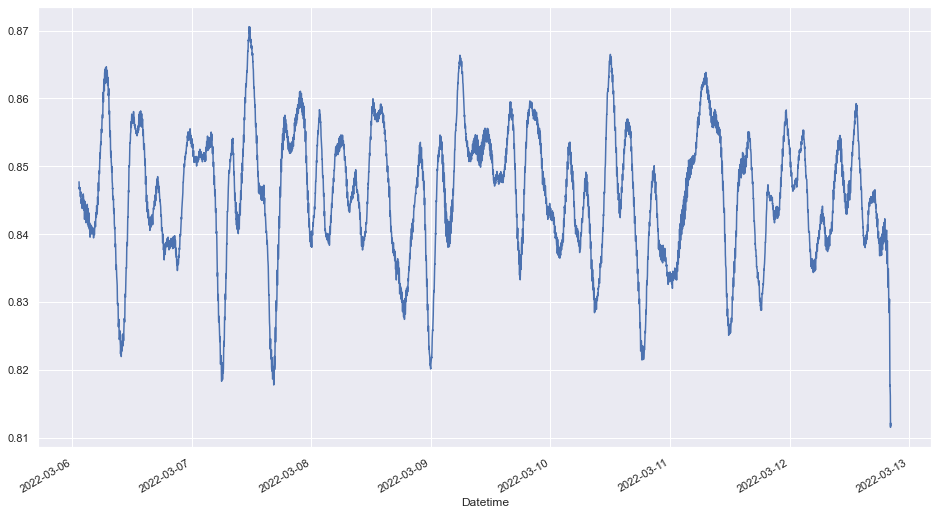

In [580]:
hind_btc.fit(lags = 100, window = 60, plot = True)

Datetime
2022-03-06 00:06:00+00:00         NaN
2022-03-06 00:07:00+00:00         NaN
2022-03-06 00:08:00+00:00         NaN
2022-03-06 00:09:00+00:00         NaN
2022-03-06 00:10:00+00:00         NaN
                               ...   
2022-03-12 20:15:00+00:00    0.810143
2022-03-12 20:16:00+00:00    0.808801
2022-03-12 20:17:00+00:00    0.805187
2022-03-12 20:18:00+00:00    0.806875
2022-03-12 20:19:00+00:00    0.807252
Length: 8046, dtype: float64

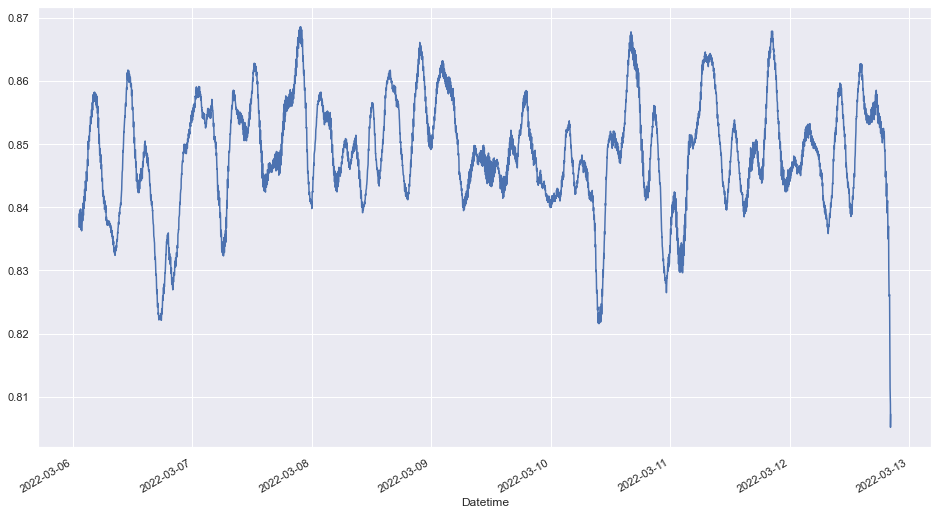

In [581]:
hind_eth.fit(lags = 100, window = 60, plot = True)

Datetime
2022-03-06 00:07:00+00:00         NaN
2022-03-06 00:08:00+00:00         NaN
2022-03-06 00:09:00+00:00         NaN
2022-03-06 00:10:00+00:00         NaN
2022-03-06 00:11:00+00:00         NaN
                               ...   
2022-03-12 20:15:00+00:00    0.812093
2022-03-12 20:16:00+00:00    0.809547
2022-03-12 20:17:00+00:00    0.806899
2022-03-12 20:18:00+00:00    0.806406
2022-03-12 20:19:00+00:00    0.804828
Length: 7563, dtype: float64

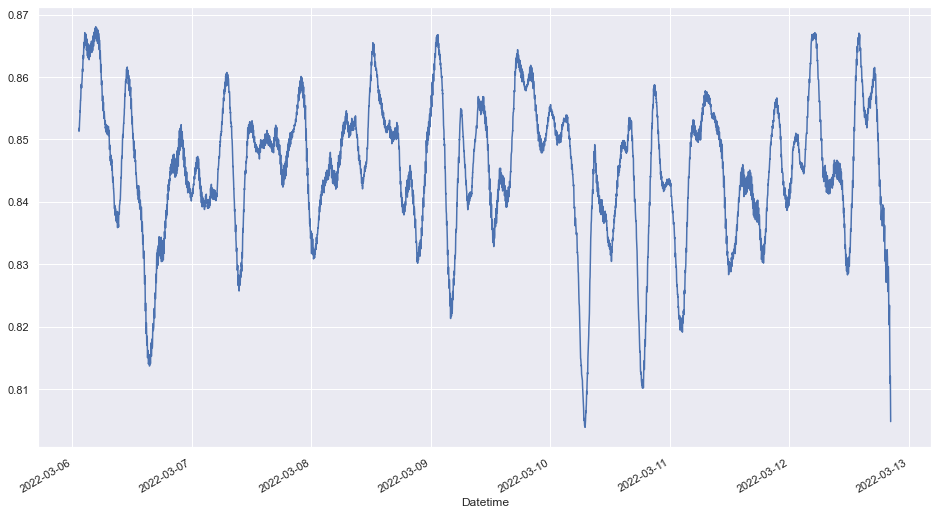

In [582]:
hind_ltc.fit(lags = 100, window = 60, plot = True)

Datetime
2022-03-06 00:06:00+00:00         NaN
2022-03-06 00:07:00+00:00         NaN
2022-03-06 00:08:00+00:00         NaN
2022-03-06 00:09:00+00:00         NaN
2022-03-06 00:10:00+00:00         NaN
                               ...   
2022-03-12 20:15:00+00:00    0.793580
2022-03-12 20:16:00+00:00    0.791376
2022-03-12 20:17:00+00:00    0.789167
2022-03-12 20:18:00+00:00    0.788127
2022-03-12 20:19:00+00:00    0.786458
Length: 7903, dtype: float64

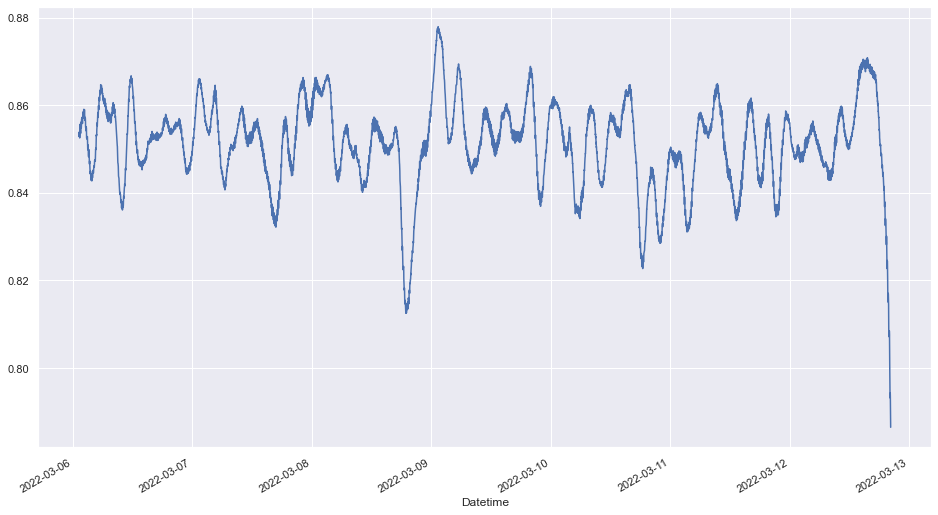

In [583]:
hind_xrp.fit(lags = 100, window = 60, plot = True)

# Conclusion 


From the above analysis we see that the class of strategies which should be considered to be profitable are indeed trend following strategies.